In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from itertools import product
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

### Setting inital data and parameters

In [3]:
START_DATE = '2024-01-01'
END_DATE = (datetime.now()+timedelta(days=-1)).strftime('%Y-%m-%d')
end_date_index = (datetime.now()+timedelta(days=-2)).strftime('%Y-%m-%d')
PRIMARY_PAIR = 'EURILS=X'

format_string = "%Y-%m-%d" # Specifies the format of the input strings

dt_obj1 = datetime.strptime(START_DATE, format_string)
dt_obj2 = datetime.strptime(END_DATE, format_string)

delta = dt_obj2 - dt_obj1

time_back_window = min(int(delta.days*0.04//1),60)
forecast = 182 # half a year

In [4]:
df = yf.download(PRIMARY_PAIR, start=START_DATE, end=END_DATE, progress=False)
#df['rate'] = (df['Low']+df['High']+df['Open']+df['Close'])/4
#df['rate'] = (df['Low']+df['High'])/2
#df['rate'] = (df['Open']+df['High'])/2
df['rate'] = df['High']
df = df[['rate']]
df

Price,rate
Ticker,
Date,
2024-01-01,3.971200
2024-01-02,4.010600
2024-01-03,4.000000
2024-01-04,4.005500
2024-01-05,4.044100
...,...
2026-02-05,3.681536
2026-02-06,3.692870


In [5]:
full_range = pd.date_range(start=START_DATE, end=end_date_index, freq='D')

df_full = df.reindex(full_range)
df_full = df_full.bfill()
df_full.index.name = 'date'
df_full = df_full.reset_index()
df=df_full
df = df.ffill()
df

Price,date,rate
Ticker,,
0,2024-01-01,3.971200
1,2024-01-02,4.010600
2,2024-01-03,4.000000
3,2024-01-04,4.005500
4,2024-01-05,4.044100
...,...,...
768,2026-02-07,3.692815
769,2026-02-08,3.692815
770,2026-02-09,3.692815


In [6]:
df_train = df[:-time_back_window]
df_train

Price,date,rate
Ticker,,
0,2024-01-01,3.971200
1,2024-01-02,4.010600
2,2024-01-03,4.000000
3,2024-01-04,4.005500
4,2024-01-05,4.044100
...,...,...
738,2026-01-08,3.711385
739,2026-01-09,3.697052
740,2026-01-10,3.698764


In [7]:
def calculate_optimal_cv_initial(data_length, forecast_horizon_days=30, target_folds=20, 
                                   min_ratio=3, max_initial_days=None):
        """
        Calculate optimal cv_initial that maximizes validation folds
        
        Parameters:
        -----------
        forecast_horizon_days : int
            Desired forecast horizon in days
        target_folds : int
            Target minimum number of validation folds (default: 20)
        min_ratio : float
            Minimum ratio of cv_initial to cv_horizon (default: 3)
        max_initial_days : int
            Maximum cv_initial in days (default: None = 80% of data)
            
        #Fold validations are (data_length - cv_initial) / forecast_horizon_days
        """
        
        # Constraints
        min_initial_seasonality = 400  # Need at least 1 year for yearly seasonality
        min_initial_ratio = forecast_horizon_days * min_ratio
        min_initial = max(min_initial_seasonality, min_initial_ratio)
        
        # Maximum initial: leave enough data for target_folds
        if max_initial_days is None:
            max_initial_days = int(data_length * 0.8)  # Use at most 80% for initial
        
        max_initial_from_folds = data_length - (forecast_horizon_days * target_folds)
        max_initial = min(max_initial_days, max_initial_from_folds)
        
        # Check if we have enough data
        if max_initial < min_initial:
            print("\n" + "="*70)
            print("⚠️  WARNING: Not enough data for target folds!")
            print("="*70)
            print(f"Data length: {data_length} days")
            print(f"Minimum cv_initial needed: {min_initial} days")
            print(f"Maximum cv_initial possible: {max_initial} days")
            print(f"Forecast horizon: {forecast_horizon_days} days")
        
        # Find optimal cv_initial that maximizes folds while respecting constraints
        # Start with minimum and check if we can achieve target folds
        max_folds = (data_length - min_initial) / forecast_horizon_days
        
        if max_folds >= target_folds:
            # We can achieve target folds, find the smallest initial that does so
            print(f"Found better option for maximum folds: {max_folds} with the min_initial")
        
        # Calculate final metrics
        cv_initial = max(min_initial,max_initial)
        actual_folds = (data_length - cv_initial) / forecast_horizon_days
        ratio = cv_initial / forecast_horizon_days
        
        # Display results
        print("\n" + "="*70)
        print("📊 Optimal Cross-Validation Parameters Calculated")
        print("="*70)
        print(f"Data length: {data_length} days ({data_length/365:.1f} years)")
        print(f"Forecast horizon: {forecast_horizon_days} days")
        print(f"\n✓ Optimal cv_initial: {cv_initial} days ({cv_initial/365:.1f} years)")
        print(f"  Ratio (initial:horizon): {ratio:.1f}:1")
        print(f"  Expected validation folds: {int(actual_folds)}")
        
        # Quality assessment
        print(f"\n📈 Quality Assessment:")
        if actual_folds >= target_folds:
            print(f"   ✓✓ Excellent! Achieved target of {target_folds}+ folds")
        elif actual_folds >= 15:
            print(f"   ✓ Very good! {int(actual_folds)} folds (target: {target_folds})")
        elif actual_folds >= 10:
            print(f"   ✓ Good! {int(actual_folds)} folds (target: {target_folds})")
        elif actual_folds >= 5:
            print(f"   ⚠️  Acceptable. {int(actual_folds)} folds (fewer than target {target_folds})")
        else:
            print(f"   ❌ Warning! Only {int(actual_folds)} folds - results may be unreliable")
        
        if ratio >= 10:
            print(f"   ✓✓ Excellent ratio ({ratio:.1f}:1)")
        elif ratio >= 4:
            print(f"   ✓ Good ratio ({ratio:.1f}:1)")
        elif ratio >= 3:
            print(f"   ⚠️  Minimum acceptable ratio ({ratio:.1f}:1)")
        else:
            print(f"   ❌ Ratio too small ({ratio:.1f}:1) - may miss patterns")
        
        print("="*70 + "\n")
        
        return cv_initial

In [8]:
cv_initial = calculate_optimal_cv_initial(data_length=len(df),forecast_horizon_days=time_back_window,target_folds=12)

Found better option for maximum folds: 12.433333333333334 with the min_initial

📊 Optimal Cross-Validation Parameters Calculated
Data length: 773 days (2.1 years)
Forecast horizon: 30 days

✓ Optimal cv_initial: 413 days (1.1 years)
  Ratio (initial:horizon): 13.8:1
  Expected validation folds: 12

📈 Quality Assessment:
   ✓✓ Excellent! Achieved target of 12+ folds
   ✓✓ Excellent ratio (13.8:1)



In [9]:
cv_initial

413

In [10]:
class CurrencyForecaster:
    """
    Complete Prophet-based currency exchange rate forecasting system
    with hyperparameter tuning and comprehensive visualization
    """
    
    def __init__(self, df, date_col='date', value_col='rate'):
        """
        Initialize forecaster with currency data
        
        Parameters:
        -----------
        df : pandas DataFrame
            Currency data from Yahoo Finance
        date_col : str
            Name of the date column
        value_col : str
            Name of the exchange rate column (typically 'Close')
        """
        # Prepare data in Prophet format
        self.df = df[[date_col, value_col]].copy()
        self.df_train = df_train[[date_col, value_col]].copy()
        self.df.columns = ['ds', 'y']
        self.df['ds'] = pd.to_datetime(self.df['ds'])
        self.df = self.df.sort_values('ds').reset_index(drop=True)
        self.df_train.columns = ['ds', 'y']
        self.df_train['ds'] = pd.to_datetime(self.df_train['ds'])
        self.df_train = self.df_train.sort_values('ds').reset_index(drop=True)
        
        # Remove any NaN values
        self.df = self.df.dropna()
        self.df_train = self.df_train.dropna()
        
        print(f"Data loaded: {len(self.df)} records from {self.df['ds'].min()} to {self.df['ds'].max()}")
        print(f"Exchange rate range: {self.df['y'].min():.4f} to {self.df['y'].max():.4f}")
        
        print(f"Training Data: {len(self.df_train)} records from {self.df_train['ds'].min()} to {self.df_train['ds'].max()}")
        print(f"Exchange rate range: {self.df_train['y'].min():.4f} to {self.df_train['y'].max():.4f}")
        
        self.best_model = None
        self.best_params = None
        self.forecast = None
        
    def tune_hyperparameters(self, param_grid=None, cv_horizon='30 days', cv_initial='365 days'):
        """
        Perform grid search for best Prophet hyperparameters
        
        Parameters:
        -----------
        param_grid : dict
            Dictionary of parameters to tune
        cv_horizon : str
            Forecast horizon for cross-validation
        cv_initial : str
            Initial training period for cross-validation
        """
        if param_grid is None:
            # Default parameter grid for currency forecasting
            param_grid = {
                'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
                'seasonality_prior_scale': [0.005,0.01, 0.1, 1.0],
                'seasonality_mode': ['additive', 'multiplicative'],
                'changepoint_range': [0.85,0.9,0.95]
            }
        
        print("\n" + "="*60)
        print(f"Starting Hyperparameter Tuning on initial {cv_initial} with horizon of {cv_horizon}")
        print("="*60)
        
        # Generate all parameter combinations
        keys = param_grid.keys()
        values = param_grid.values()
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        results = []
        
        for i, params in enumerate(param_combinations, 1):
            try:
                # Train model with current parameters
                model = Prophet(**params, daily_seasonality=True, weekly_seasonality=True, 
                               yearly_seasonality=True)
                model.fit(self.df)
                
                # Cross-validation
                df_cv = cross_validation(model, initial=cv_initial, horizon=cv_horizon, 
                                        parallel="processes")
                df_metrics = performance_metrics(df_cv)
                
                # Store results
                mae = df_metrics['mae'].mean()
                rmse = df_metrics['rmse'].mean()
                mape = df_metrics['mape'].mean()
                
                results.append({
                    'params': params,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'score': mae  # Using MAE as primary metric
                })
                
                if i % 5 == 0:
                    print(f"Progress: {i}/{len(param_combinations)} - Current best MAE: {min(r['mae'] for r in results):.6f}")
                
            except Exception as e:
                print(f"Error with params {params}: {str(e)}")
                continue
        
        # Find best parameters
        best_result = min(results, key=lambda x: x['score'])
        self.best_params = best_result['params']
        
        print("\n" + "="*60)
        print("Hyperparameter Tuning Complete!")
        print("="*60)
        print(f"Best Parameters: {self.best_params}")
        print(f"Best MAE: {best_result['mae']:.6f}")
        print(f"Best RMSE: {best_result['rmse']:.6f}")
        print(f"Best MAPE: {best_result['mape']:.4f}%")
        
        return self.best_params, results
    
    def train_best_model(self, params=None):
        """
        Train the final model with best parameters
        
        Parameters:
        -----------
        params : dict
            Model parameters (uses self.best_params if None)
        """
        if params is None:
            if self.best_params is None:
                print("No tuned parameters found. Using default parameters.")
                params = {
                    'changepoint_prior_scale': 0.05,
                    'seasonality_prior_scale': 1.0,
                    'seasonality_mode': 'multiplicative',
                    'changepoint_range': 0.9
                }
            else:
                params = self.best_params
        
        print("\n" + "="*60)
        print("Training Final Model")
        print("="*60)
        
        self.best_model = Prophet(**params, daily_seasonality=True, 
                                 weekly_seasonality=True, yearly_seasonality=True)
        self.best_model.fit(self.df_train)
        
        print("Model trained successfully!")
        
        # Evaluate on training data
        in_sample_forecast = self.best_model.predict(self.df_train)
        mae = mean_absolute_error(self.df_train['y'], in_sample_forecast['yhat'])
        rmse = np.sqrt(mean_squared_error(self.df_train['y'], in_sample_forecast['yhat']))
        r2 = r2_score(self.df_train['y'], in_sample_forecast['yhat'])
        
        print(f"\nIn-sample Performance:")
        print(f"  MAE:  {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  R²:   {r2:.4f}")
        
        return self.best_model
    
    def create_forecast(self, periods=182, freq='D'):
        """
        Generate future predictions
        
        Parameters:
        -----------
        periods : int
            Number of periods to forecast
        freq : str
            Frequency ('D' for daily, 'W' for weekly, 'M' for monthly)
        """
        if self.best_model is None:
            raise ValueError("Model not trained. Call train_best_model() first.")
        
        print(f"\nGenerating {periods}-period forecast...")
        
        future = self.best_model.make_future_dataframe(periods=periods, freq=freq)
        self.forecast = self.best_model.predict(future)
        
        # Show forecast summary
        future_only = self.forecast[self.forecast['ds'] > self.df_train['ds'].max()]
        print(f"\nForecast Summary:")
        print(f"  Forecast start: {future_only['ds'].min()}")
        print(f"  Forecast end:   {future_only['ds'].max()}")
        print(f"  Predicted range: {future_only['yhat'].min():.4f} to {future_only['yhat'].max():.4f}")
        
        return self.forecast
    
    def plot_trends(self, save_path=None):
        """
        Create comprehensive visualization suite
        
        Parameters:
        -----------
        save_path : str
            Path to save figures (optional)
        """
        if self.forecast is None:
            raise ValueError("No forecast available. Call create_forecast() first.")
        
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(15, 8))
        
        
        
        # Manually plot components
        forecast_data = self.forecast
        
        # Trend
        ax1.plot(forecast_data['ds'], forecast_data['trend'], color='blue', linewidth=2)
        ax1.set_title('Trend Component', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Trend', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Weekly seasonality
        if 'weekly' in forecast_data.columns:
            ax2.plot(forecast_data['ds'][:time_back_window], forecast_data['weekly'][:time_back_window], color='green', linewidth=2)
            ax2.set_title('Weekly Seasonality', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Date', fontsize=12)
            ax2.set_ylabel('Weekly Effect', fontsize=12)
            ax2.grid(True, alpha=0.3)
        
        # Yearly seasonality
        if 'yearly' in forecast_data.columns:
            ax3.plot(forecast_data['ds'], forecast_data['yearly'], color='orange', linewidth=2)
            ax3.set_title('Yearly Seasonality', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Date', fontsize=12)
            ax3.set_ylabel('Yearly Effect', fontsize=12)
            ax3.grid(True, alpha=0.3)    
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\nPlots saved to {save_path}")
        
        plt.show()
    
    
    def plot_residuals(self):
        
        historical = self.forecast[self.forecast['ds'].isin(self.df['ds'])]
        residuals = self.df['y'].values - historical['yhat'].values
        plt.figure(figsize=(10, 8))
        plt.scatter(historical['ds'], residuals)
        plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
        plt.title("Residuals Regression")
        plt.xlabel("Date")
        plt.ylabel("Residual")
        plt.grid(True, alpha=0.3)
        plt.show()
        
    
    def _plot_forecast_distribution(self):
        """Plot distribution of future forecasted values"""
        future_only = self.forecast[self.forecast['ds'] > self.df['ds'].max()]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        ax1.hist(future_only['yhat'], bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax1.axvline(future_only['yhat'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {future_only['yhat'].mean():.4f}")
        ax1.set_title('Distribution of Forecasted Exchange Rates', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Exchange Rate', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plot over time (monthly)
        future_only['month'] = future_only['ds'].dt.to_period('M')
        monthly_data = [group['yhat'].values for name, group in future_only.groupby('month')]
        months = [str(name) for name, _ in future_only.groupby('month')]
        
        ax2.boxplot(monthly_data, labels=months)
        ax2.set_title('Monthly Forecast Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Exchange Rate', fontsize=12)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_forecast_table(self, n_days=30):
        """
        Get forecast as a formatted table
        
        Parameters:
        -----------
        n_days : int
            Number of future days to display
        """
        future_only = self.forecast[self.forecast['ds'] > self.df['ds'].max()].head(n_days)
        
        result = future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        result.columns = ['Date', 'Forecast', 'Lower Bound', 'Upper Bound']
        result['Date'] = result['Date'].dt.date
        
        print(f"\n{'='*70}")
        print(f"Forecast Table - Next {n_days} Days")
        print('='*70)
        print(result.to_string(index=False))
        print('='*70)
        
        return result
    
    
    def plot_details(self,dayss=700):
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        
        self.best_model.plot(self.forecast, ax=ax1)
        ax1.set_title('Exchange Rate Forecast with Uncertainty', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Exchange Rate', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        
        cutoff_date = self.df['ds'].max() - pd.Timedelta(days=dayss)
        recent_actual = self.df[self.df['ds'] >= cutoff_date]
        cutoff_date_pred = self.df_train['ds'].max()
        recent_actual_pred = self.df[self.df['ds'] >= cutoff_date_pred]
        recent_predictions = self.forecast[self.forecast['ds'].isin(recent_actual_pred['ds'])]
        future_forecast = self.forecast[self.forecast['ds'] > self.df['ds'].max()]
        
        ax2.plot(recent_actual['ds'], recent_actual['y'], color='black', label='Actual', linewidth=1)
        ax2.plot(recent_predictions['ds'], recent_predictions['yhat'], color='red', 
                label=f'Model Prediction (Last {time_back_window}d)', linewidth=2, alpha=0.7, zorder=2)
        ax2.plot(future_forecast['ds'], future_forecast['yhat'], 'b-', label='Forecast', linewidth=1)
        ax2.fill_between(future_forecast['ds'], 
                         future_forecast['yhat_lower'], 
                         future_forecast['yhat_upper'], 
                         alpha=0.3, color='blue', label='Uncertainty')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

### Training

In [11]:
forecaster = CurrencyForecaster(df, date_col='date', value_col='rate')

# Tune (takes 5-15 minutes depending on data size)
# Gives (Data - cv_initial) / cv_horizon fold validations
best_params, results = forecaster.tune_hyperparameters(cv_horizon=f'{time_back_window} days',cv_initial=f'{cv_initial} days')

Data loaded: 773 records from 2024-01-01 00:00:00 to 2026-02-11 00:00:00
Exchange rate range: 3.6555 to 4.2909
Training Data: 743 records from 2024-01-01 00:00:00 to 2026-01-12 00:00:00
Exchange rate range: 3.6915 to 4.2909

Starting Hyperparameter Tuning on initial 413 days with horizon of 30 days
Testing 96 parameter combinations...


15:05:28 - cmdstanpy - INFO - Chain [1] start processing
15:05:29 - cmdstanpy - INFO - Chain [1] done processing
15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing
15:06:01 - cmdstanpy - INFO - Chain [1] start processing
15:06:01 - cmdstanpy - INFO - Chain [1] done processing
15:06:16 - cmdstanpy - INFO - Chain [1] start processing
15:06:16 - cmdstanpy - INFO - Chain [1] done processing
15:06:32 - cmdstanpy - INFO - Chain [1] start processing
15:06:32 - cmdstanpy - INFO - Chain [1] done processing


Progress: 5/96 - Current best MAE: 0.142115


15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:49 - cmdstanpy - INFO - Chain [1] done processing
15:07:04 - cmdstanpy - INFO - Chain [1] start processing
15:07:04 - cmdstanpy - INFO - Chain [1] done processing
15:07:20 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:37 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:53 - cmdstanpy - INFO - Chain [1] start processing
15:07:53 - cmdstanpy - INFO - Chain [1] done processing


Progress: 10/96 - Current best MAE: 0.142115


15:08:08 - cmdstanpy - INFO - Chain [1] start processing
15:08:09 - cmdstanpy - INFO - Chain [1] done processing
15:08:24 - cmdstanpy - INFO - Chain [1] start processing
15:08:24 - cmdstanpy - INFO - Chain [1] done processing
15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] done processing
15:08:56 - cmdstanpy - INFO - Chain [1] start processing
15:08:56 - cmdstanpy - INFO - Chain [1] done processing
15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:12 - cmdstanpy - INFO - Chain [1] done processing


Progress: 15/96 - Current best MAE: 0.142115


15:09:29 - cmdstanpy - INFO - Chain [1] start processing
15:09:29 - cmdstanpy - INFO - Chain [1] done processing
15:09:44 - cmdstanpy - INFO - Chain [1] start processing
15:09:45 - cmdstanpy - INFO - Chain [1] done processing
15:10:00 - cmdstanpy - INFO - Chain [1] start processing
15:10:00 - cmdstanpy - INFO - Chain [1] done processing
15:10:16 - cmdstanpy - INFO - Chain [1] start processing
15:10:16 - cmdstanpy - INFO - Chain [1] done processing
15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing


Progress: 20/96 - Current best MAE: 0.142115


15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:46 - cmdstanpy - INFO - Chain [1] done processing
15:11:01 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:33 - cmdstanpy - INFO - Chain [1] start processing
15:11:33 - cmdstanpy - INFO - Chain [1] done processing
15:11:49 - cmdstanpy - INFO - Chain [1] start processing
15:11:49 - cmdstanpy - INFO - Chain [1] done processing


Progress: 25/96 - Current best MAE: 0.142115


15:12:06 - cmdstanpy - INFO - Chain [1] start processing
15:12:06 - cmdstanpy - INFO - Chain [1] done processing
15:12:22 - cmdstanpy - INFO - Chain [1] start processing
15:12:23 - cmdstanpy - INFO - Chain [1] done processing
15:12:39 - cmdstanpy - INFO - Chain [1] start processing
15:12:39 - cmdstanpy - INFO - Chain [1] done processing
15:12:56 - cmdstanpy - INFO - Chain [1] start processing
15:12:56 - cmdstanpy - INFO - Chain [1] done processing
15:13:13 - cmdstanpy - INFO - Chain [1] start processing
15:13:13 - cmdstanpy - INFO - Chain [1] done processing


Progress: 30/96 - Current best MAE: 0.138101


15:13:30 - cmdstanpy - INFO - Chain [1] start processing
15:13:31 - cmdstanpy - INFO - Chain [1] done processing
15:13:48 - cmdstanpy - INFO - Chain [1] start processing
15:13:49 - cmdstanpy - INFO - Chain [1] done processing
15:14:10 - cmdstanpy - INFO - Chain [1] start processing
15:14:10 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:31 - cmdstanpy - INFO - Chain [1] done processing
15:14:49 - cmdstanpy - INFO - Chain [1] start processing
15:14:49 - cmdstanpy - INFO - Chain [1] done processing


Progress: 35/96 - Current best MAE: 0.138101


15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:29 - cmdstanpy - INFO - Chain [1] start processing
15:15:30 - cmdstanpy - INFO - Chain [1] done processing
15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing
15:16:08 - cmdstanpy - INFO - Chain [1] start processing
15:16:08 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1] done processing


Progress: 40/96 - Current best MAE: 0.125770


15:16:46 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:17:06 - cmdstanpy - INFO - Chain [1] start processing
15:17:07 - cmdstanpy - INFO - Chain [1] done processing
15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:26 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing


Progress: 45/96 - Current best MAE: 0.114851


15:18:21 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:05 - cmdstanpy - INFO - Chain [1] start processing
15:19:06 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1] done processing


Progress: 50/96 - Current best MAE: 0.093767


15:20:12 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:21:21 - cmdstanpy - INFO - Chain [1] start processing
15:21:22 - cmdstanpy - INFO - Chain [1] done processing
15:21:43 - cmdstanpy - INFO - Chain [1] start processing
15:21:44 - cmdstanpy - INFO - Chain [1] done processing


Progress: 55/96 - Current best MAE: 0.093104


15:22:06 - cmdstanpy - INFO - Chain [1] start processing
15:22:09 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing
15:22:31 - cmdstanpy - INFO - Chain [1] done processing
15:22:51 - cmdstanpy - INFO - Chain [1] start processing
15:22:52 - cmdstanpy - INFO - Chain [1] done processing
15:23:11 - cmdstanpy - INFO - Chain [1] start processing
15:23:12 - cmdstanpy - INFO - Chain [1] done processing
15:23:31 - cmdstanpy - INFO - Chain [1] start processing
15:23:33 - cmdstanpy - INFO - Chain [1] done processing


Progress: 60/96 - Current best MAE: 0.093104


15:23:51 - cmdstanpy - INFO - Chain [1] start processing
15:23:52 - cmdstanpy - INFO - Chain [1] done processing
15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:14 - cmdstanpy - INFO - Chain [1] done processing
15:24:34 - cmdstanpy - INFO - Chain [1] start processing
15:24:36 - cmdstanpy - INFO - Chain [1] done processing
15:24:56 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:25:19 - cmdstanpy - INFO - Chain [1] start processing
15:25:20 - cmdstanpy - INFO - Chain [1] done processing


Progress: 65/96 - Current best MAE: 0.093104


15:25:41 - cmdstanpy - INFO - Chain [1] start processing
15:25:44 - cmdstanpy - INFO - Chain [1] done processing
15:26:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:06 - cmdstanpy - INFO - Chain [1] done processing
15:26:27 - cmdstanpy - INFO - Chain [1] start processing
15:26:29 - cmdstanpy - INFO - Chain [1] done processing
15:26:50 - cmdstanpy - INFO - Chain [1] start processing
15:26:52 - cmdstanpy - INFO - Chain [1] done processing
15:27:15 - cmdstanpy - INFO - Chain [1] start processing
15:27:18 - cmdstanpy - INFO - Chain [1] done processing


Progress: 70/96 - Current best MAE: 0.093104


15:27:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:48 - cmdstanpy - INFO - Chain [1] done processing
15:28:18 - cmdstanpy - INFO - Chain [1] start processing
15:28:22 - cmdstanpy - INFO - Chain [1] done processing
15:28:50 - cmdstanpy - INFO - Chain [1] start processing
15:28:52 - cmdstanpy - INFO - Chain [1] done processing
15:29:16 - cmdstanpy - INFO - Chain [1] start processing
15:29:18 - cmdstanpy - INFO - Chain [1] done processing
15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:44 - cmdstanpy - INFO - Chain [1] done processing


Progress: 75/96 - Current best MAE: 0.093104


15:30:05 - cmdstanpy - INFO - Chain [1] start processing
15:30:07 - cmdstanpy - INFO - Chain [1] done processing
15:30:30 - cmdstanpy - INFO - Chain [1] start processing
15:30:32 - cmdstanpy - INFO - Chain [1] done processing
15:30:57 - cmdstanpy - INFO - Chain [1] start processing
15:30:59 - cmdstanpy - INFO - Chain [1] done processing
15:31:23 - cmdstanpy - INFO - Chain [1] start processing
15:31:25 - cmdstanpy - INFO - Chain [1] done processing
15:31:49 - cmdstanpy - INFO - Chain [1] start processing
15:31:51 - cmdstanpy - INFO - Chain [1] done processing


Progress: 80/96 - Current best MAE: 0.093104


15:32:15 - cmdstanpy - INFO - Chain [1] start processing
15:32:17 - cmdstanpy - INFO - Chain [1] done processing
15:32:38 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing
15:33:23 - cmdstanpy - INFO - Chain [1] start processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing
15:33:46 - cmdstanpy - INFO - Chain [1] start processing
15:33:47 - cmdstanpy - INFO - Chain [1] done processing


Progress: 85/96 - Current best MAE: 0.093104


15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:31 - cmdstanpy - INFO - Chain [1] start processing
15:34:32 - cmdstanpy - INFO - Chain [1] done processing
15:34:52 - cmdstanpy - INFO - Chain [1] start processing
15:34:54 - cmdstanpy - INFO - Chain [1] done processing
15:35:16 - cmdstanpy - INFO - Chain [1] start processing
15:35:18 - cmdstanpy - INFO - Chain [1] done processing
15:35:40 - cmdstanpy - INFO - Chain [1] start processing
15:35:43 - cmdstanpy - INFO - Chain [1] done processing


Progress: 90/96 - Current best MAE: 0.093104


15:36:04 - cmdstanpy - INFO - Chain [1] start processing
15:36:05 - cmdstanpy - INFO - Chain [1] done processing
15:36:26 - cmdstanpy - INFO - Chain [1] start processing
15:36:27 - cmdstanpy - INFO - Chain [1] done processing
15:36:48 - cmdstanpy - INFO - Chain [1] start processing
15:36:50 - cmdstanpy - INFO - Chain [1] done processing
15:37:10 - cmdstanpy - INFO - Chain [1] start processing
15:37:12 - cmdstanpy - INFO - Chain [1] done processing
15:37:37 - cmdstanpy - INFO - Chain [1] start processing
15:37:39 - cmdstanpy - INFO - Chain [1] done processing


Progress: 95/96 - Current best MAE: 0.093104


15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:06 - cmdstanpy - INFO - Chain [1] done processing



Hyperparameter Tuning Complete!
Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
Best MAE: 0.093104
Best RMSE: 0.118128
Best MAPE: 0.0240%


### Best Model

In [12]:
# Train with best parameters
forecaster.train_best_model()

# Forecast forecast days ahead
forecaster.create_forecast(periods=forecast, freq='D')


Training Final Model


15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:31 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully!

In-sample Performance:
  MAE:  0.029608
  RMSE: 0.036846
  R²:   0.9372

Generating 182-period forecast...

Forecast Summary:
  Forecast start: 2026-01-13 00:00:00
  Forecast end:   2026-07-13 00:00:00
  Predicted range: 3.5665 to 3.8286


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2024-01-01,4.039372,4.054344,4.142684,4.039372,4.039372,0.006243,0.006243,0.006243,0.014026,...,0.000010,0.000010,0.000010,0.007773,0.007773,0.007773,0.0,0.0,0.0,4.096029
1,2024-01-02,4.039523,4.040973,4.135416,4.039523,4.039523,0.006243,0.006243,0.006243,0.012823,...,-0.000580,-0.000580,-0.000580,0.007160,0.007160,0.007160,0.0,0.0,0.0,4.091323
2,2024-01-03,4.039674,4.043793,4.138023,4.039674,4.039674,0.006243,0.006243,0.006243,0.012701,...,-0.000040,-0.000040,-0.000040,0.006497,0.006497,0.006497,0.0,0.0,0.0,4.090981
3,2024-01-04,4.039825,4.038200,4.138641,4.039825,4.039825,0.006243,0.006243,0.006243,0.011911,...,-0.000128,-0.000128,-0.000128,0.005796,0.005796,0.005796,0.0,0.0,0.0,4.087945
4,2024-01-05,4.039977,4.042502,4.135973,4.039977,4.039977,0.006243,0.006243,0.006243,0.011765,...,0.000455,0.000455,0.000455,0.005066,0.005066,0.005066,0.0,0.0,0.0,4.087506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,2026-07-09,3.644451,2.779401,4.316517,2.828821,4.386976,0.006243,0.006243,0.006243,-0.017784,...,-0.000128,-0.000128,-0.000128,-0.023900,-0.023900,-0.023900,0.0,0.0,0.0,3.579637
921,2026-07-10,3.644143,2.776395,4.323856,2.820590,4.391561,0.006243,0.006243,0.006243,-0.018323,...,0.000455,0.000455,0.000455,-0.025021,-0.025021,-0.025021,0.0,0.0,0.0,3.577372
922,2026-07-11,3.643835,2.773670,4.315818,2.814398,4.396363,0.006243,0.006243,0.006243,-0.019651,...,0.000088,0.000088,0.000088,-0.025982,-0.025982,-0.025982,0.0,0.0,0.0,3.572229
923,2026-07-12,3.643527,2.748265,4.310884,2.806506,4.400987,0.006243,0.006243,0.006243,-0.020316,...,0.000195,0.000195,0.000195,-0.026754,-0.026754,-0.026754,0.0,0.0,0.0,3.569505


### Plots

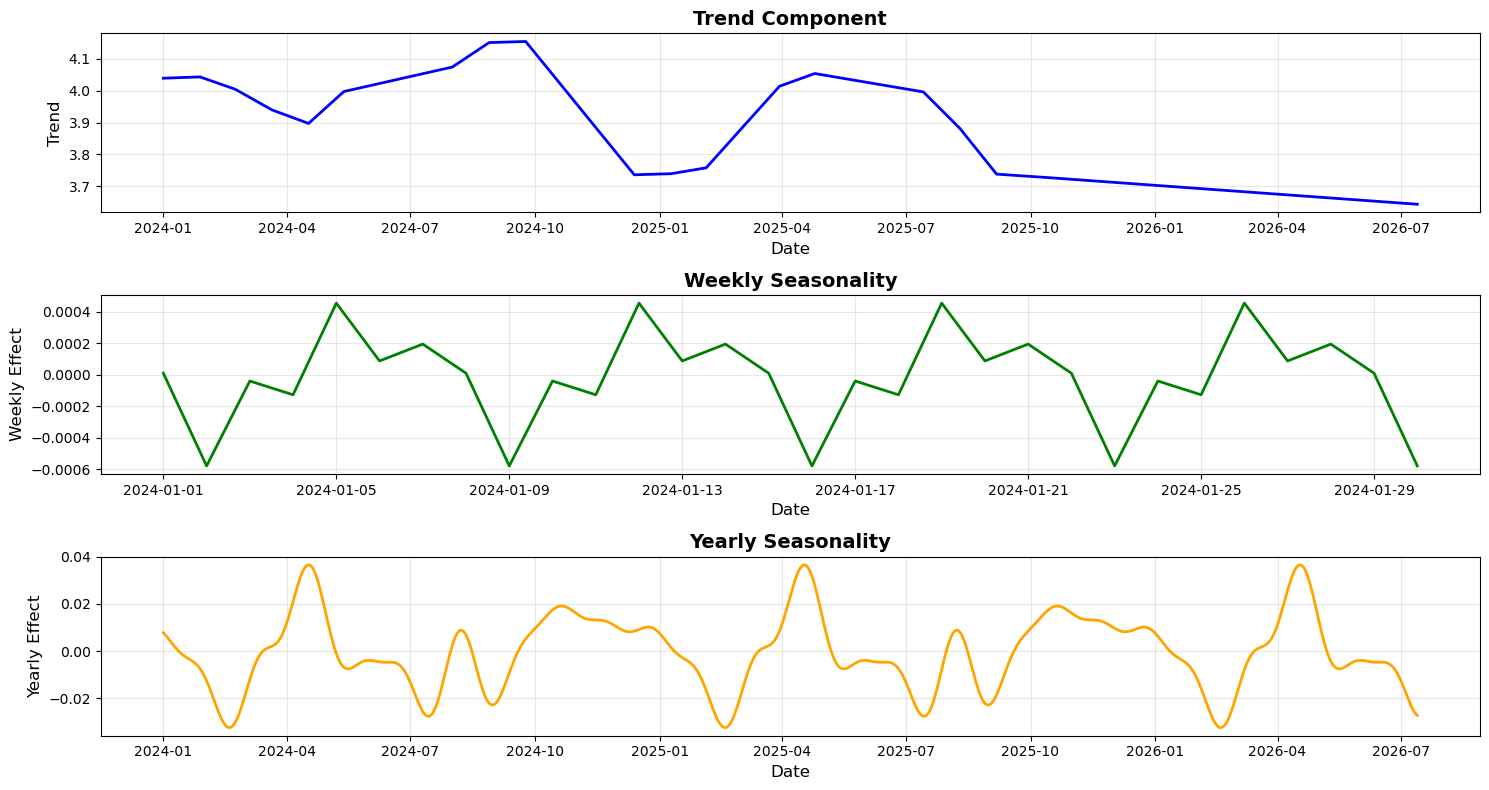

In [13]:
forecaster.plot_trends()

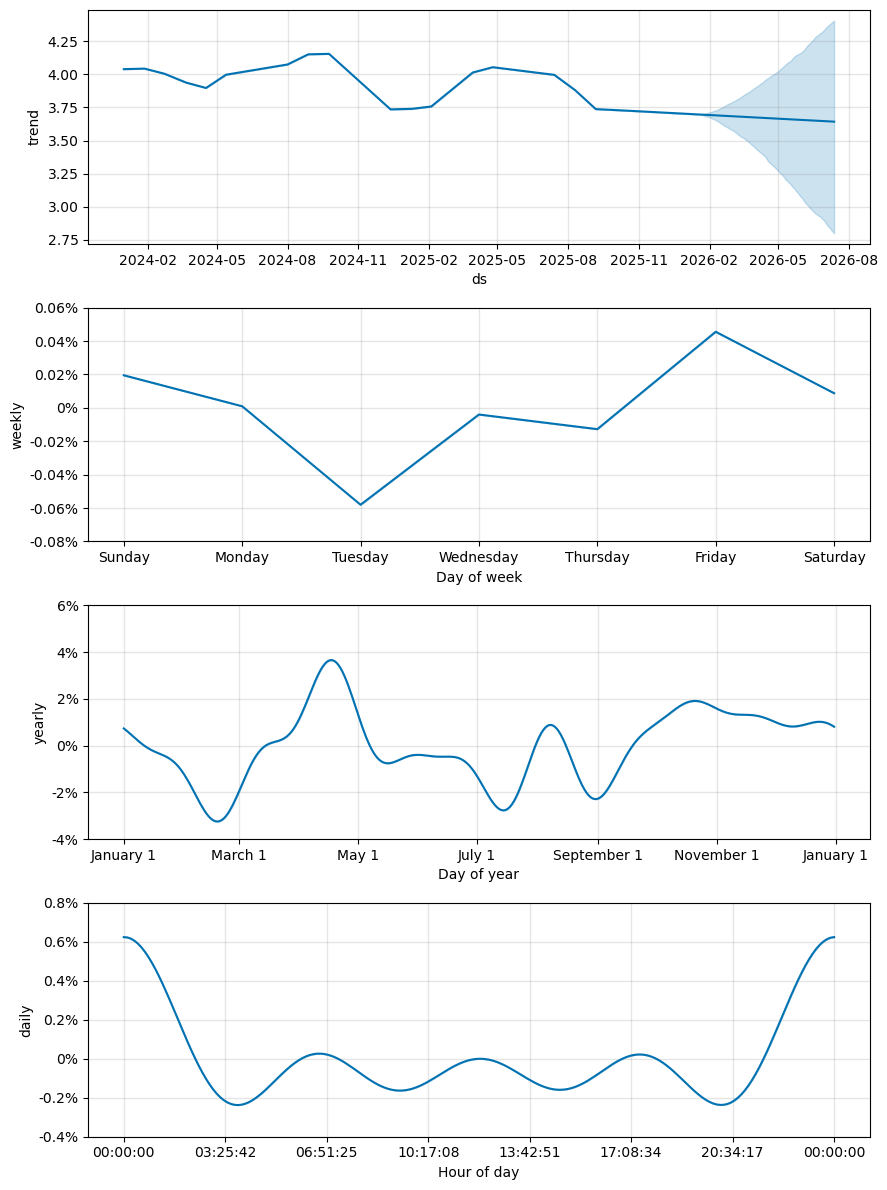

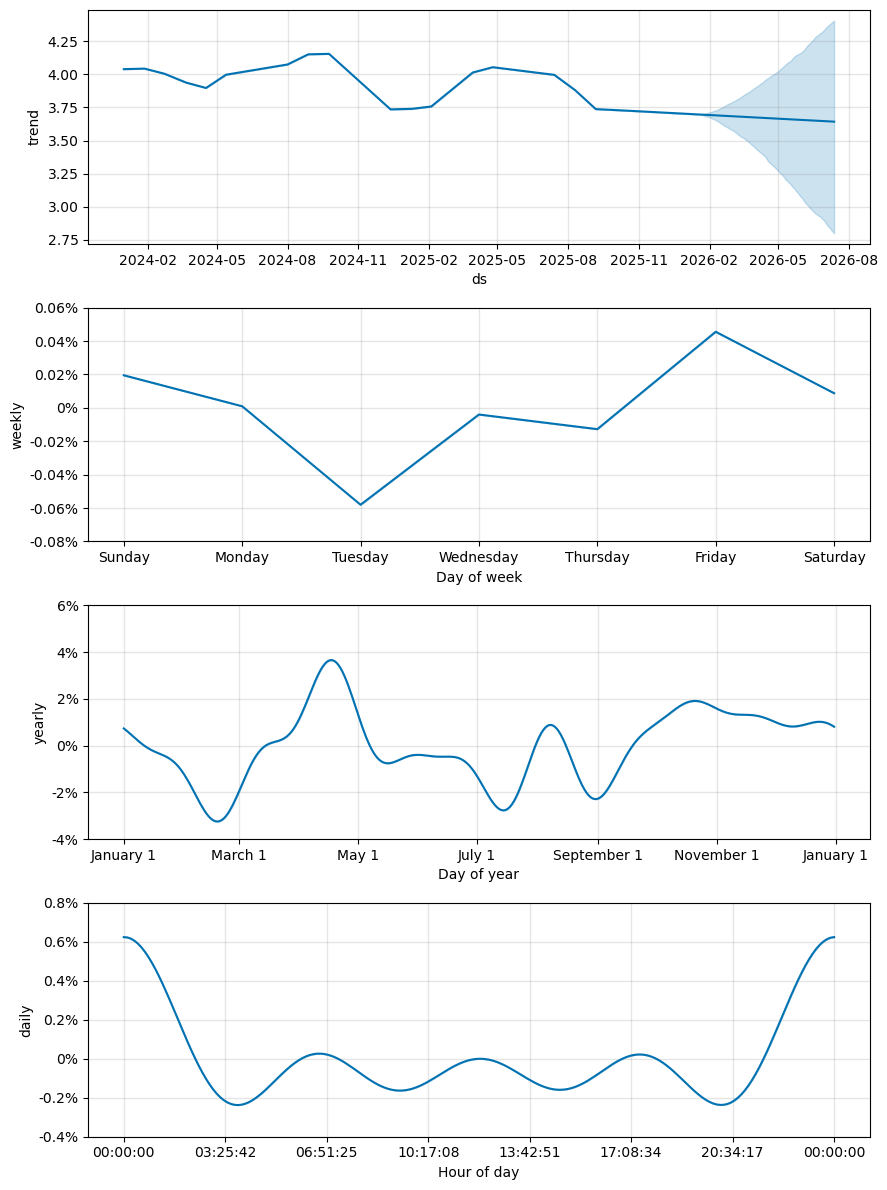

In [14]:
forecaster.best_model.plot_components(forecaster.forecast)

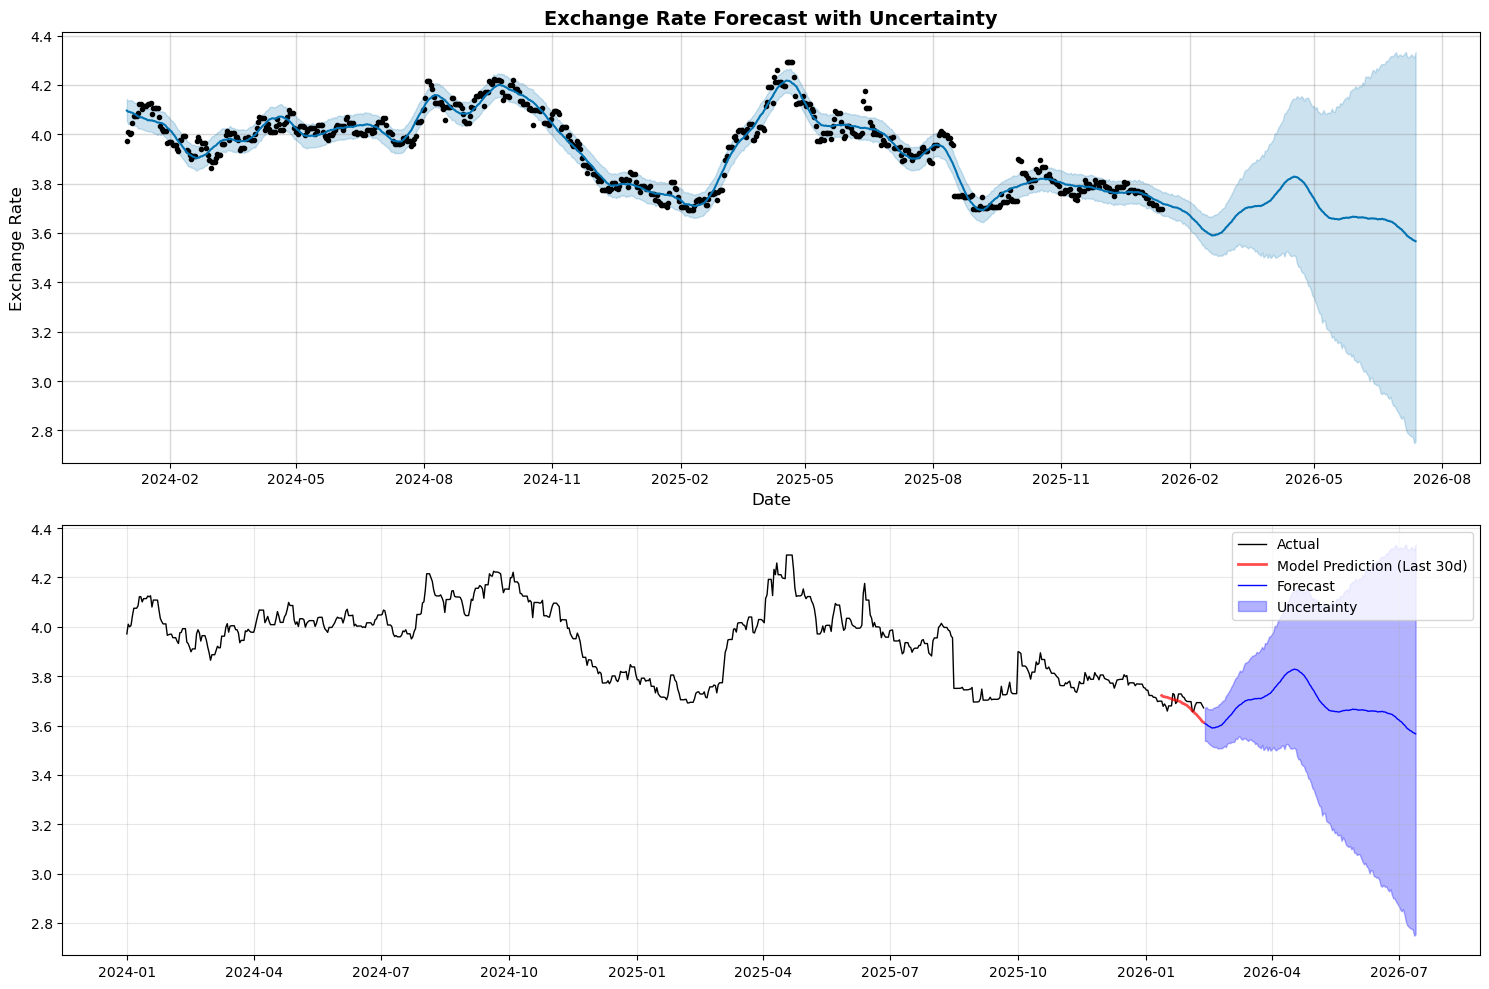

In [15]:
forecaster.plot_details(dayss=int(delta.days))

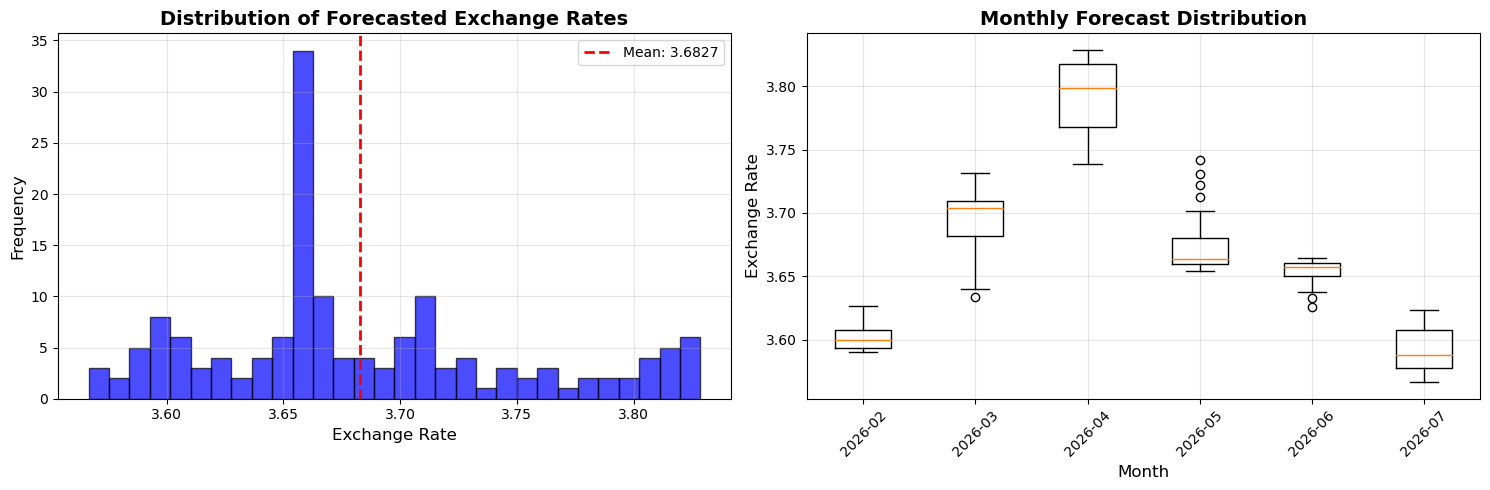

In [16]:
forecaster._plot_forecast_distribution()

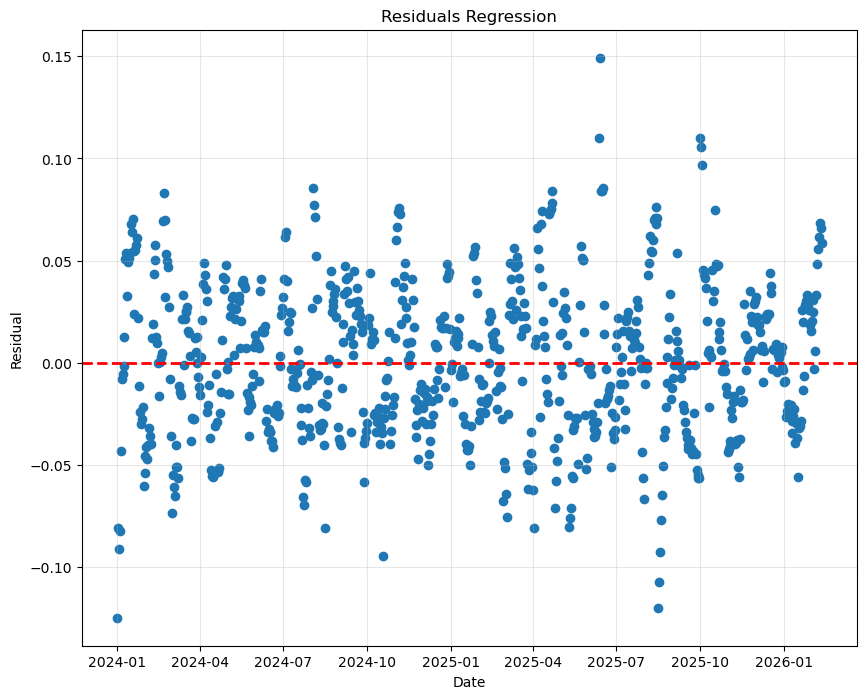

In [17]:
forecaster.plot_residuals()

In [18]:
forecaster.get_forecast_table(n_days=90)


Forecast Table - Next 90 Days
      Date  Forecast  Lower Bound  Upper Bound
2026-02-12  3.607592     3.537291     3.672661
2026-02-13  3.605183     3.538091     3.674857
2026-02-14  3.599868     3.532298     3.668001
2026-02-15  3.596985     3.525658     3.665077
2026-02-16  3.593772     3.520992     3.667179
2026-02-17  3.589873     3.516835     3.664915
2026-02-18  3.590987     3.513269     3.671264
2026-02-19  3.590660     3.512140     3.673306
2026-02-20  3.593688     3.513331     3.676286
2026-02-21  3.594086     3.507184     3.676079
2026-02-22  3.597088     3.507390     3.685439
2026-02-23  3.599821     3.508928     3.688323
2026-02-24  3.601818     3.507299     3.695438
2026-02-25  3.608663     3.512012     3.700787
2026-02-26  3.613792     3.517453     3.703283
2026-02-27  3.621895     3.512654     3.719868
2026-02-28  3.626894     3.526489     3.726036
2026-03-01  3.633932     3.530127     3.736113
2026-03-02  3.640066     3.528152     3.745455
2026-03-03  3.644773     3.53

,Date,Forecast,Lower Bound,Upper Bound
773,2026-02-12,3.607592,3.537291,3.672661
774,2026-02-13,3.605183,3.538091,3.674857
775,2026-02-14,3.599868,3.532298,3.668001
776,2026-02-15,3.596985,3.525658,3.665077
777,2026-02-16,3.593772,3.520992,3.667179
...,...,...,...,...
858,2026-05-08,3.683679,3.245616,4.098288
859,2026-05-09,3.676519,3.244898,4.083632
860,2026-05-10,3.671865,3.213016,4.081172
861,2026-05-11,3.666913,3.208502,4.088510
